In [1]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.15.0', '1.26.2')

In [2]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "Signature_Dataset"

def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [3]:
def define_dataset(directory):
    folders = os.listdir(directory)
    train_list, test_list = {}, {}
    train_label, test_label = {}, {}
    
    # Creating Train-list
    for folder in folders:
        num_files = len(os.listdir(os.path.join(directory, folder + "/Train"))) - 1
        train_list[folder] = num_files
        train_label_files = glob.glob(os.path.join(directory, folder, "Train", "*.csv"))
        if train_label_files:
            label_data = pd.read_csv(train_label_files[0])
            label_data.set_index('image_name', inplace=True)
            label_data.sort_index(inplace=True)
            train_label[folder] = label_data['label']
            train_label[folder] = train_label[folder].apply(lambda x: 1 if x == 'real' else 0)
            
     # Creating Test-list
    for folder in folders:
        num_files = len(os.listdir(os.path.join(directory, folder + "/Test"))) - 1
        test_list[folder] = num_files  
        test_label_files = glob.glob(os.path.join(directory, folder, "Test", "*.csv"))
        if test_label_files:
            label_data = pd.read_csv(test_label_files[0])
            label_data.set_index('image_name', inplace=True)
            label_data.sort_index(inplace=True)
            test_label[folder] = label_data['label']
            test_label[folder] = test_label[folder].apply(lambda x: 1 if x == 'real' else 0)
    
    return train_list, test_list, train_label, test_label

train_list, test_list, train_label, test_label = define_dataset(ROOT)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTrain List:", train_list)
print("\nTest List:", test_list)

Length of training list: 5
Length of testing list : 5

Train List: {'personA': 40, 'personB': 40, 'personC': 40, 'personD': 40, 'personE': 40}

Test List: {'personA': 8, 'personB': 8, 'personC': 8, 'personD': 8, 'personE': 8}


In [4]:
def create_triplets(directory, folder_list, folder_label, train = False):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        if train:
            path = os.path.join(directory, folder, "Train")
        else:
            path = os.path.join(directory, folder, "Test")
        files = list(os.listdir(path))
        files = [file for file in files if file.endswith('.png')]
        num_files = len(files)
        
        for k in range(num_files):
            
            if folder_label[folder][k] == 1:
                anchor = files[k]
                anchor_path = os.path.join(path, anchor)
                
                for i in range(num_files):
                    if folder_label[folder][i] == 1:
                        positive = files[i]
                        positive_path = os.path.join(path, positive)
                        
                        for j in range(num_files):

                            if folder_label[folder][j] == 0:
                                negative = files[j]
                                negative_path = os.path.join(path, negative)
                                
                                triplets.append([anchor_path, positive_path, negative_path])
            
    random.shuffle(triplets)
    return triplets

In [5]:
train_triplet = create_triplets(ROOT, train_list, train_label , train = True)
test_triplet  = create_triplets(ROOT, test_list, test_label, train = False)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

train_triplet = train_triplet[:2500]
print("\nExamples of train triplets:")
for i in range(5):
    print(train_triplet[i])

print("\nExamples of test triplets:")
for i in range(5):
    print(test_triplet[i])

C:\Users\ahmed\AppData\Local\Temp\ipykernel_15356\2214686921.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if folder_label[folder][k] == 1:
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15356\2214686921.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if folder_label[folder][i] == 1:
C:\Users\ahmed\AppData\Local\Temp\ipykernel_15356\2214686921.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if folder_label[folder][j] =

Number of training triplets: 40000
Number of testing triplets : 320

Examples of train triplets:
['Signature_Dataset\\personA\\Train\\personA_25.png', 'Signature_Dataset\\personA\\Train\\personA_26.png', 'Signature_Dataset\\personA\\Train\\personA_24.png']
['Signature_Dataset\\personA\\Train\\personA_15.png', 'Signature_Dataset\\personA\\Train\\personA_8.png', 'Signature_Dataset\\personA\\Train\\personA_34.png']
['Signature_Dataset\\personA\\Train\\personA_35.png', 'Signature_Dataset\\personA\\Train\\personA_19.png', 'Signature_Dataset\\personA\\Train\\personA_5.png']
['Signature_Dataset\\personE\\Train\\personE_42.png', 'Signature_Dataset\\personE\\Train\\personE_5.png', 'Signature_Dataset\\personE\\Train\\personE_14.png']
['Signature_Dataset\\personE\\Train\\personE_29.png', 'Signature_Dataset\\personE\\Train\\personE_3.png', 'Signature_Dataset\\personE\\Train\\personE_24.png']

Examples of test triplets:
['Signature_Dataset\\personA\\Test\\personA_13.png', 'Signature_Dataset\\person

In [11]:
def get_batch(triplet_list, batch_size=256):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(cv2.cvtColor(cv2.resize(read_image(a), (200, 200)), cv2.COLOR_BGR2RGB))
            positive.append(cv2.cvtColor(cv2.resize(read_image(p), (200, 200)), cv2.COLOR_BGR2RGB))
            negative.append(cv2.cvtColor(cv2.resize(read_image(n), (200, 200)), cv2.COLOR_BGR2RGB))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        yield ([anchor, positive, negative])

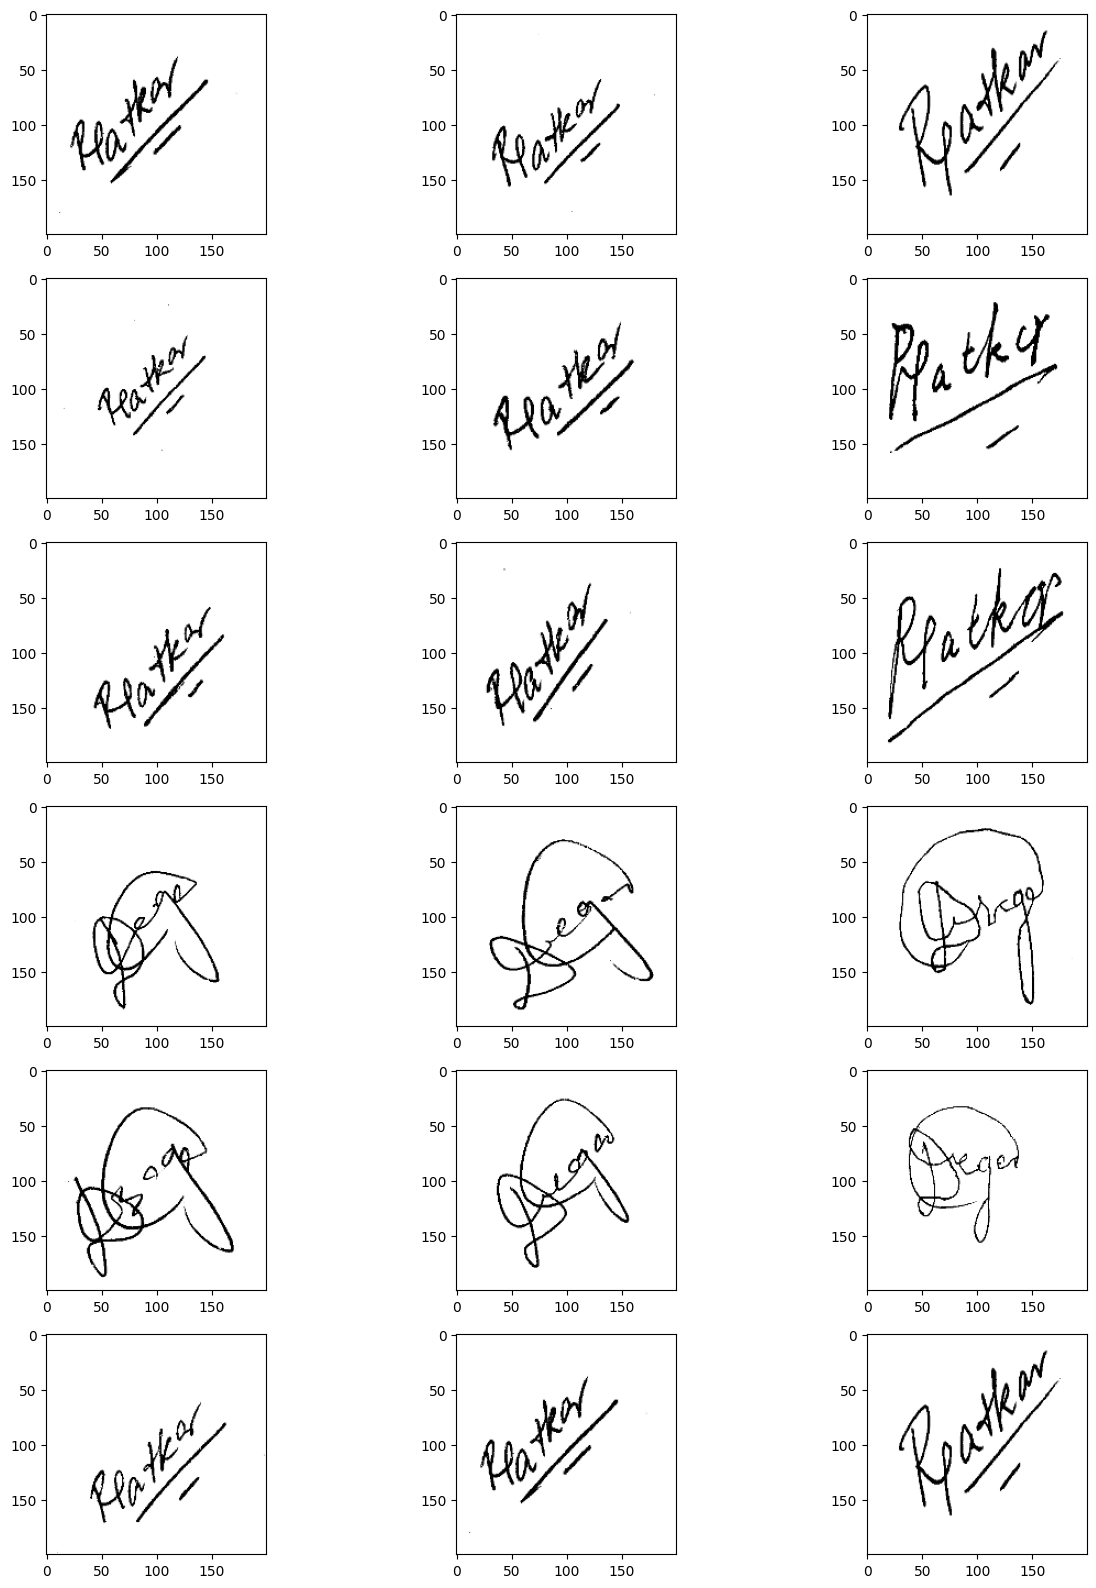

In [12]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [13]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [14]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg', 
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [15]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
def get_siamese_network(input_shape = (200, 200,3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()



Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 200, 200, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 200, 200, 3)]        0         []                            
 )                                                                                                
                                                                                  

In [16]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [17]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [18]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [35]:
save_all = False
epochs = 5
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]

     # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 339 sec)
Loss on train    = 0.39218
2/2 [==============================] - 5s 2s/step
Accuracy on test = 0.89687

EPOCH: 2 	 (Epoch done in 323 sec)
Loss on train    = 0.29503
2/2 [==============================] - 4s 2s/step
Accuracy on test = 0.85000

EPOCH: 3 	 (Epoch done in 261 sec)
Loss on train    = 0.29408
2/2 [==============================] - 4s 2s/step
Accuracy on test = 0.95000

EPOCH: 4 	 (Epoch done in 267 sec)
Loss on train    = 0.18787
2/2 [==============================] - 4s 2s/step
Accuracy on test = 0.87813

EPOCH: 5 	 (Epoch done in 265 sec)
Loss on train    = 0.19513
2/2 [==============================] - 4s 2s/step
Accuracy on test = 0.84062


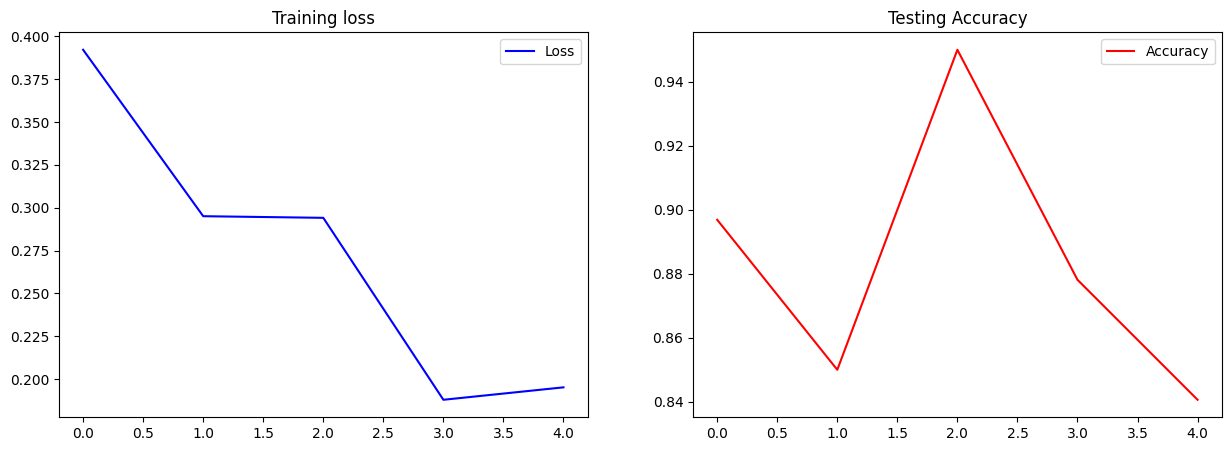

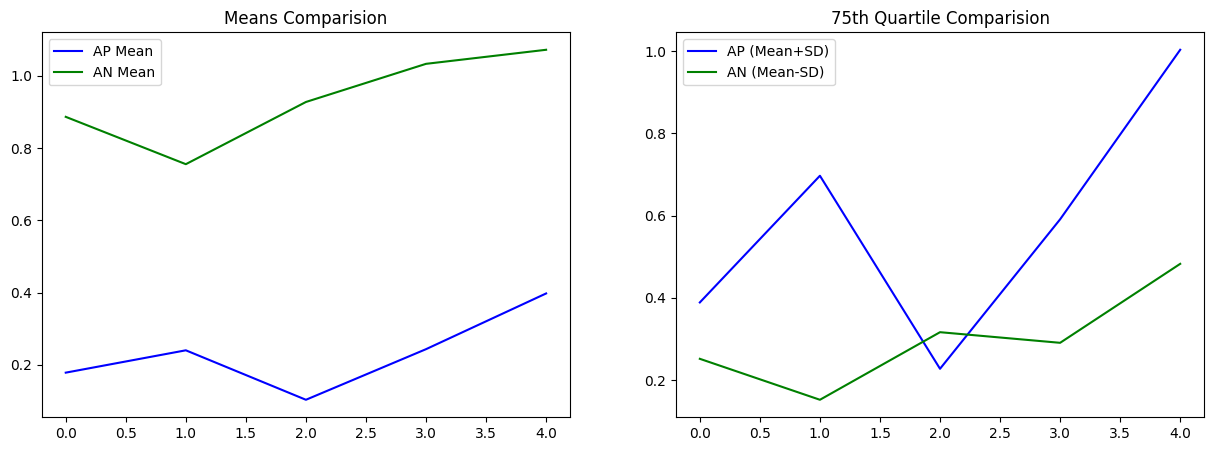

In [36]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [37]:
def extract_encoder(model):
    encoder = get_encoder((200, 200, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_14 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 lambda_2 (Lambda)           (None, 256)               0         
                                                      

In [38]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 6s 770ms/step

Accuracy of model: 0.611328125



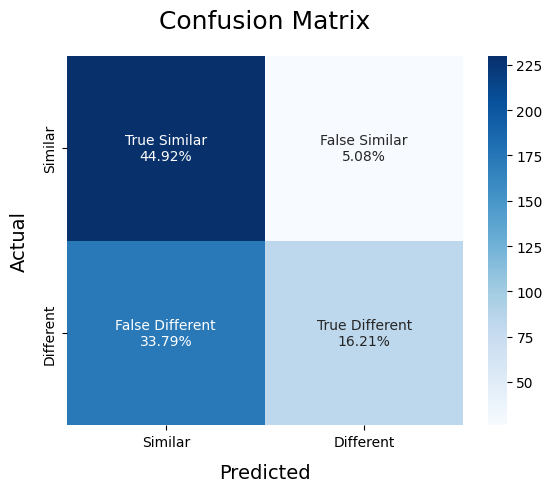

In [39]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

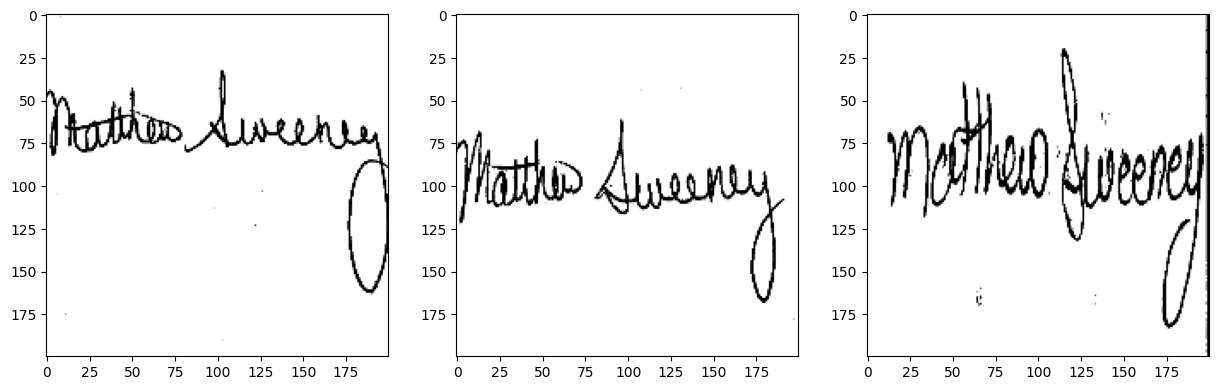

In [40]:
def visualize_triplet(triplet):
    a, p, n = triplet
    a = cv2.cvtColor(cv2.resize(read_image(a), (200, 200)), cv2.COLOR_BGR2RGB)
    p = cv2.cvtColor(cv2.resize(read_image(p), (200, 200)), cv2.COLOR_BGR2RGB)
    n = cv2.cvtColor(cv2.resize(read_image(n), (200, 200)), cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(a)
    axes[1].imshow(p)
    axes[2].imshow(n)
    plt.show()

visualize_triplet(test_triplet[20])

In [41]:
a, p, n = test_triplet[20]
a = np.expand_dims(cv2.cvtColor(cv2.resize(read_image(a), (200, 200)), cv2.COLOR_BGR2RGB), axis=0)
p = np.expand_dims(cv2.cvtColor(cv2.resize(read_image(p), (200, 200)), cv2.COLOR_BGR2RGB), axis=0)
n = np.expand_dims(cv2.cvtColor(cv2.resize(read_image(n), (200, 200)), cv2.COLOR_BGR2RGB), axis=0)

print("Prediction on Anchor and Positive:", classify_images(a, p))
print("Prediction on Anchor and Negative:", classify_images(a, n))

1/1 [==============================] - 0s 59ms/step
Prediction on Anchor and Positive: [1]
1/1 [==============================] - 0s 58ms/step
Prediction on Anchor and Negative: [0]
